# Feature-based clustering of time-series data

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler
)

from sktime.transformations.panel.catch22 import Catch22
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

In [2]:
def generate_sample(df: pd.DataFrame, n: int=1872) -> pd.DataFrame:
    df = pd.read_csv("df_clean.csv")
    df["date"] = pd.to_datetime(df["date"])

    if "Unnamed: 0" in df.columns:
        df.drop(columns=['Unnamed: 0'], inplace=True)

    np.random.seed(11) # set random seed for reproducibility

    uuid_list = df["uuid"].unique().tolist()
    uuid_random = np.random.choice(uuid_list, n, replace=False)

    # Random subset consisting of 500 uuid samples
    df_random = df[df["uuid"].isin(uuid_random)]

    df_transformed = df_random.set_index(["uuid", "date"])[["ndvi"]]

    return df_transformed

In [3]:
df = pd.read_csv("df_clean.csv")

df_transformed = generate_sample(df)

In [4]:
df_transformed

ndvi
uuid                                 date             
000f5041-32c0-4a8a-b139-83bf4845d9e6 2020-01-02  0.661
                                     2020-01-07  0.661
                                     2020-01-12  0.655
                                     2020-01-17  0.597
                                     2020-01-22  0.559
...                                                ...
ffe88305-d0d2-446f-9674-60ea1fd8be85 2024-12-06  0.573
                                     2024-12-11  0.573
                                     2024-12-16  0.491
                                     2024-12-21  0.491
                                     2024-12-26  0.491

[683280 rows x 1 columns]

In [5]:
def timeseries_features(df: pd.DataFrame, scaler: TransformerMixin) -> pd.DataFrame:
    """ 
    This function extracts time-series features by using Catch22 on the dataframe
    by scaling the data using a given transformer.
    """
    
    ts_features = Catch22(catch24=True).fit_transform(df)
    ts_features_scaled = pd.DataFrame(scaler().fit_transform(ts_features))
    nan_cols = ts_features_scaled.columns[(ts_features.isna()).any()]
    ts_features_scaled = ts_features_scaled.drop(columns=nan_cols)

    return ts_features_scaled

### PCA

PCA is not able to identify clusters for any data scaling. For the `RobustScaler` there is evidence of two clusters. The poor performance of PCA suggest that the data exhibits nonlinearities.

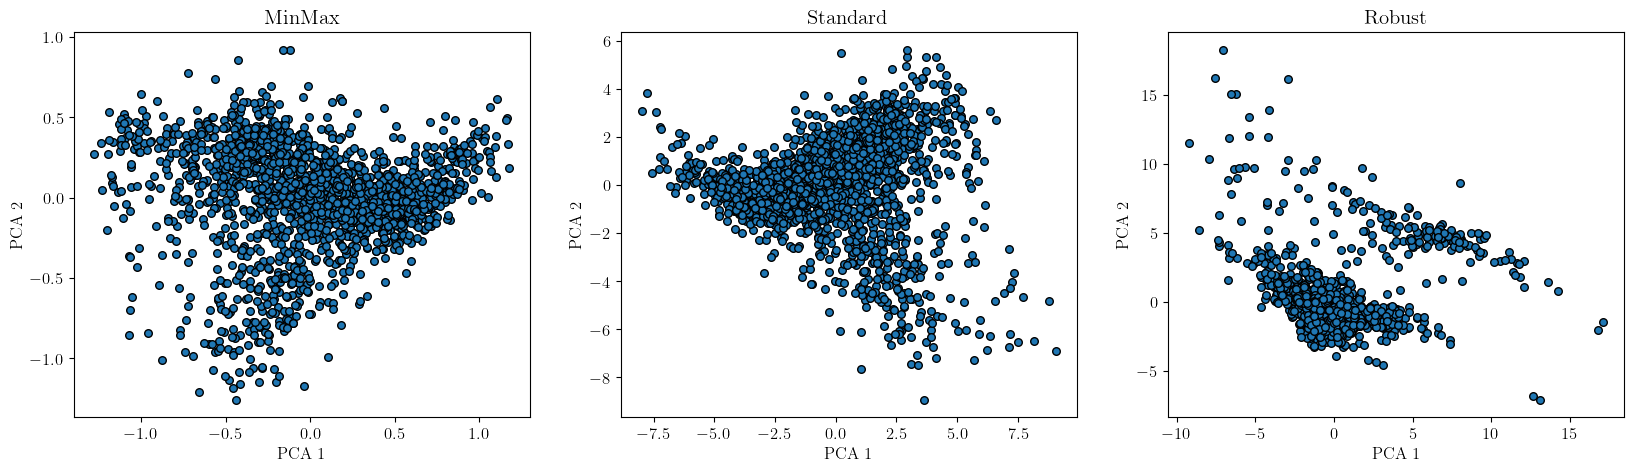

In [6]:
scalers_labels = ["MinMax", "Standard", "Robust"]
scalers = [MinMaxScaler, StandardScaler, RobustScaler]

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

for i, scaler in enumerate(scalers):
    pca = PCA(n_components=2)

    ts_features = timeseries_features(df_transformed, scaler)
    X = pca.fit_transform(ts_features)

    ax[i].scatter(X[:, 0], X[:, 1], s=30, edgecolor="k")
    ax[i].set_xlabel("PCA 1", fontsize=12)
    ax[i].set_ylabel("PCA 2", fontsize=12)
    ax[i].set_title(scalers_labels[i], fontsize=15)
plt.show()

### UMAP

UMAP succeeds at isolating clusters, which PCA does not. This probably hints at the fact the data is nonlinear or resides on some kind of curved manifold. 

In [7]:
# Append scaled ts_features df in a list
df_list = [timeseries_features(df_transformed, scaler) for scaler in scalers]
df_dict = dict(zip(scalers_labels, df_list))

# Viz. Dashboards

In [8]:
from umap import UMAP
from sklearn.cluster import DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture

df = df_dict["Standard"]
X = UMAP(
    n_components=3, 
    n_neighbors=15, 
    densmap=True,
    random_state=15).fit_transform(df)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [9]:
from ipywidgets import FloatSlider, IntSlider, Dropdown, VBox
import plotly.graph_objects as go
from IPython.display import display


# Create a persistent FigureWidget
scatter = go.Scatter3d(
    x=X[:, 0],
    y=X[:, 1],
    z=X[:, 2],
    mode='markers',
    marker=dict(
        color=np.zeros(X.shape[0]),  # initially all zeros
        colorscale='Viridis',
        size=5,
        line=dict(color='black', width=0.5)
    ),
    text=[f'Label: {0}' for _ in range(X.shape[0])],
    hoverinfo='text'
)

fig = go.FigureWidget(
    data=[scatter],
    layout=go.Layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            xaxis=dict(range=[-0.1, 1.1]),
            yaxis=dict(range=[-0.1, 1.1]),
            zaxis=dict(range=[-0.1, 1.1])
        ),
        title="3D Scatter Plot of Embeddings with DBSCAN Labels",
        width=800,
        height=800
    )
)

# Create widgets
eps_slider = FloatSlider(value=0.3, min=0.1, max=2.0, step=0.01, description='eps')
min_samples_slider = IntSlider(value=5, min=1, max=20, step=1, description='min_samples')
metric_dropdown = Dropdown(
    options=["euclidean", "cosine", "manhattan"],
    value="euclidean",
    description="metric"
)

# Define the update function
def update_plot(change=None):
    dbscan = DBSCAN(
        eps=eps_slider.value,
        min_samples=min_samples_slider.value,
        metric=metric_dropdown.value,
        algorithm="kd_tree"
    ).fit(X)
    labels = dbscan.labels_

    # Update the figure
    with fig.batch_update():
        fig.data[0].marker.color = labels
        fig.data[0].text = [f'Label: {l}' for l in labels]

# Attach the update function to widget changes
eps_slider.observe(update_plot, names='value')
min_samples_slider.observe(update_plot, names='value')
metric_dropdown.observe(update_plot, names='value')

# Initial plot update
update_plot()

# Display widgets and figure
display(VBox([eps_slider, min_samples_slider, metric_dropdown, fig]))
